# Spectrum of the transverse field Ising model with matrix product state methods

The Hamiltonian of the transverse field Ising (TFI) model reads

$$ H = -J \sum_n \sigma^x_n \sigma^x_{n+1} - g \sum_n \sigma^z_n \overset{J=1}{=} -\sum_n \sigma^x_n \sigma^x_{n+1} - g \sum_n \sigma^z_n. $$

* $\mathbb{Z}_2-\mathrm{symmetry}$: $[H, U] = 0$ with $U = \prod\limits_n \sigma^z_n$,
* Magnetization: $\langle \sigma^x \rangle = \frac{1}{N}\sum\limits_{n=1}^N \langle \sigma^x_n \rangle = \sqrt{\lim\limits_{\vert n-m \vert \to \infty} \langle \sigma^x_n\sigma^x_m \rangle}$.

From connecting the two limits of the transverse field $g$, we expect the following quantum phase diagram:

* Ferromagnetic phase $g < g_c$
	* two degenerate, symmetry broken ground states related by $U$ ($\ket{...\rightarrow\rightarrow\rightarrow...}$ and $\ket{...\leftarrow\leftarrow\leftarrow...}$ for $g = 0$)
	* $\langle \sigma^x \rangle = \pm m \neq 0$ ($m = 1$ for $g = 0$)
	* elementary excitations: topological domain walls ($\ket{...\rightarrow\rightarrow\rightarrow \leftarrow\leftarrow\leftarrow...}$ for $g = 0$)

* Paramagnetic phase $g > g_c$
	* unique symmetric ground state ($\ket{...\uparrow\uparrow\uparrow...}$ for $g \to \infty$)
	* $\langle \sigma^x \rangle = 0$
	* elementary excitations: single spin flips ($\ket{...\uparrow\uparrow \downarrow \uparrow\uparrow...}$ for $g \to \infty$)

* Quantum phase transition at $g_c$


By performing Jordan-Wigner, Fourier and Bogoliubov transformations, the TFI model with peridic boundary conditions can be diagonalized analytically. The Hamiltonian in terms of fermionic creation and annihilation operators $\gamma_{p}^{\dagger}$ and $\gamma_{p}$ reads

$$H = \sum_{p} \epsilon_p \gamma_{p}^{\dagger}\gamma_{p} + E_0.$$

Single particle excitation energy: $\epsilon_p = 2 \sqrt{1 - 2g\cos(p) + g^2}$ $\Rightarrow$ energy gap closes at quantum critical point $g_c = 1$.

Ground state energy: $E_0 = -\sum_{p} \epsilon_p/2$ $\Rightarrow$ ground state energy density in the thermodynamic limit: $e_0 = - \frac{1}{2\pi} \int_{-\pi}^{\pi} \epsilon_p/2$.

(For details see Subir Sachdev, Quantum Phase Transitions, 2nd ed, Cambridge University Press, 2011)

### Contents
1. Ground state <br>
    1.1 Infinite uniform MPS: VUMPS <br>
    1.2 Finite MPS: DMRG <br>

2. Excitations <br>
    2.1 Infinite uniform MPS: Variational perturbations in plane wave superposition <br>
    2.2 Finite MPS: Variational site dependent perturbations <br>
        - PBC MPO (and OBC MPS): Do the excitations have definite momentum? <br>
        - PBC MPO: Explicitly target momenta with effective translation operator <br>
        - PBC MPO: Local energies <br>
        - OBC MPO: Local energies <br>

In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

from a_umps import UniformMPS
from b_model_infinite import TFIModelInfinite
from c_vumps import vumps_algorithm
from d_uexcitations import VariationalPlaneWaveExcitationEngine

from a_mps import MPS
from b_model_finite import TFIModelFinite
from c_dmrg import dmrg_algorithm
from d_excitations import VariationalQuasiparticleExcitationEngine, ExcitedMPS

## 1) Ground state

### 1.1) Infinite uniform MPS: VUMPS

In [2]:
def get_infinite_tfi_gs(g, D, tol):
    """For the TFI model on an infinite chain with transverse field g, find the ground state with 
    VUMPS using a bond dimension D and a tolerance tol in gradient norm."""
    print(f"g = {g}, D = {D}:")
    tfi_model_infinite = TFIModelInfinite(g)
    h = tfi_model_infinite.get_h()
    guess_umps0 = UniformMPS.from_desired_bond_dimension(D)
    e0, umps0, var0 = vumps_algorithm(h, guess_umps0, tol)
    e0_exact = tfi_model_infinite.get_exact_gs_energy_density()
    print(f"|e0 - e0_exact| = {np.abs(e0-e0_exact)}.")
    mx0 = umps0.get_site_expectation_value(tfi_model_infinite.sigma_x)
    mz0 = umps0.get_site_expectation_value(tfi_model_infinite.sigma_z)
    print(f"Magnetization densities: {mx0} (X) and {mz0} (Z).")
    return e0, umps0, mx0

### 1.2) Finite MPS: DMRG

In [3]:
def get_finite_tfi_gs(N, bc, g, D_max, eps, num_runs):
    """For the TFI model on a finite chain of length N with boundary conditions bc and transverse 
    field g, find the ground state with num_runs DMRG runs. Allow maximal bond dimension D_max and 
    discard any singular values smaller than eps."""
    print(f"N = {N}, bc = {bc}, g = {g}, D_max = {D_max}:")
    tfi_model_finite = TFIModelFinite(N, g)
    mpo = tfi_model_finite.get_mpo(bc)
    if g >= 1:  # paramagnetic phase and critical point
        guess_mps0 = MPS.from_qubit_product_state(N, spin_orientation="up")
    elif 0 <= g < 1.:  # ferromagnetic phase 
        import random
        spin_orientations = ["right", "left"]
        spin_orientation = random.choice(spin_orientations)
        guess_mps0 = MPS.from_qubit_product_state(N, spin_orientation)
    E0, mps0, var0 = dmrg_algorithm(mpo, guess_mps0, D_max, eps, num_runs)
    if bc == "periodic":
        E0_exact = tfi_model_finite.get_exact_gs_energy()
        print(f"|E0 - E0_exact| = {np.abs(E0-E0_exact)}.")
    mx0 = np.mean(mps0.get_site_expectation_values([tfi_model_finite.sigma_x] * N))
    mz0 = np.mean(mps0.get_site_expectation_values([tfi_model_finite.sigma_z] * N))
    print(f"Mean magnetizations: {mx0} (X) and {mz0} (Z).")
    return E0, mps0, mx0

### Comparison of the quantum phase diagrams

g = 1e-05, D = 30:
AL, L: Converged up to tol=1e-10. Final error after 6 iterations: 1.0467624667850976e-13.
AR, R: Converged up to tol=1e-10. Final error after 6 iterations: 1.148194509638678e-15.
uMPS ground state converged with VUMPS up to tol=1e-10 in gradient norm. Final error after 3 iterations: 4.0789188008768034e-14.
Ground state energy density: -1.000000000024999. 
Ground state variance density: (2.3849235005978306e-26-2.9100959722984314e-26j).
|e0 - e0_exact| = 1.1102230246251565e-15.
Magnetization densities: 0.9999999999875008 (X) and 4.999999999972041e-06 (Z).
N = 100, bc = open, g = 1e-05, D_max = 30:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -99.0000000025513. 
Ground state variance: -1.2369127944111824e-10. 
Bond dimensions: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

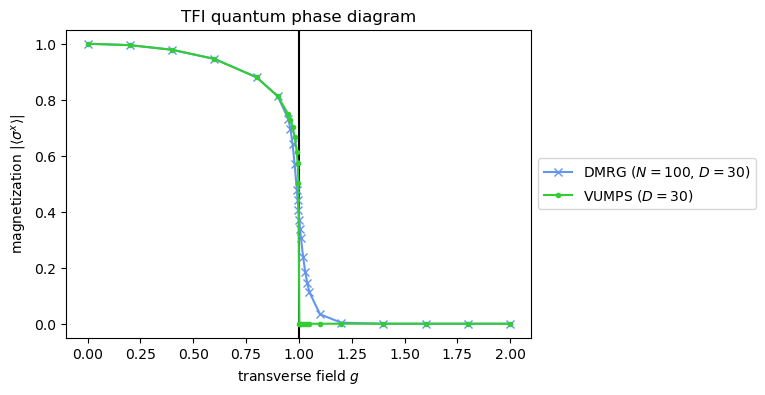

In [4]:
N = 100
D = 30
gs = [1.e-5, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.994, 0.998, \
      1.002, 1.006, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.2, 1.4, 1.6, 1.8, 2.0]
mxs_infinite = []
mxs_finite = []
for g in gs:
    _, _, mx0_infinite = get_infinite_tfi_gs(g, D, tol=1.e-10)
    mxs_infinite.append(mx0_infinite)
    _, mps0_finite, _ = get_finite_tfi_gs(N, bc="open", g=g, D_max=D, eps=1.e-16, num_runs=10)
    sigma_x = TFIModelFinite(N, g).sigma_x
    Cxs_finite, _ = mps0_finite.get_correlation_functions(sigma_x, sigma_x, N//4, 3*N//4)
    mx0_finite = np.sqrt(Cxs_finite[-1])
    mxs_finite.append(mx0_finite)

plt.figure(figsize=(6, 4))
plt.title(f"TFI quantum phase diagram")
plt.axvline(x=1.0, color="black")
plt.plot(gs, np.abs(mxs_finite), "x-", color="cornflowerblue", \
         label=f"DMRG ($N = {N}$, $D = {D}$)")
plt.plot(gs, np.abs(mxs_infinite), ".-", color="limegreen", label=f"VUMPS ($D = {D}$)")
plt.xlabel(r"transverse field $g$")
plt.ylabel(r"magnetization $\vert \langle \sigma^x \rangle \vert$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 2) Excitations

### 2.1) Infinite uniform MPS: Variational perturbations in plane wave superpositions

In [5]:
def get_infinite_tfi_excitation_dispersion(g, D, tol):
    """For the TFI model on an infinite chain with transverse field g, find the ground state with 
    VUMPS and variational plane wave excitations on top, using a bond dimension D and tolerance tol."""
    tfi_model_infinite = TFIModelInfinite(g)
    # exact analytical solution
    ps_exact, es_exact = tfi_model_infinite.get_exact_excitation_dispersion()
    # vumps and variational plane wave excitations
    h = tfi_model_infinite.get_h()
    _, umps0, _,  = get_infinite_tfi_gs(g, D, tol)
    ps = list(np.arange(-np.pi, 0, np.pi/10)) + [0] + list(np.arange(0, np.pi + np.pi/10, np.pi/10))
    # paramagnetic phase (single spin flip excitations) and critical point (gapless excitation)
    if g >= 1.:  
        es = []
        for p in ps:
            excitation_engine = VariationalPlaneWaveExcitationEngine(umps0, h, p, tol/10)
            e, _ = excitation_engine.run(k=1)
            es.append(e)
        print(f"Found dispersion relation for single particle excitations on top of ground state.")
        return ps_exact, es_exact, ps, es
    elif 0 <= g < 1:  # ferromagnetic phase (topological domain wall excitations)
        mx0 = umps0.get_site_expectation_value(tfi_model_infinite.sigma_x)
        for i in range(100):
            _, umps0_tilde, _,  = get_infinite_tfi_gs(g, D, tol)
            mx0_tilde = umps0_tilde.get_site_expectation_value(tfi_model_infinite.sigma_x)
            if np.abs(mx0 + mx0_tilde) < 1.e-5:
                print(f"Found mx0={mx0} and mx0_tilde={mx0_tilde} after {i+2} ground state searchs.")
                es = []
                for p in ps:
                    excitation_engine = VariationalPlaneWaveExcitationEngine(umps0, h, p, tol/10, \
                                                                             umps0_tilde)
                    e, _ = excitation_engine.run(k=1)
                    es.append(e)
                print(f"Found dispersion relation for single particle excitations on top of ground \
                      state.")
                return ps_exact, es_exact, ps, es  

g = 1.5, D = 10:
AL, L: Converged up to tol=1e-10. Final error after 6 iterations: 3.649649847529029e-13.
AR, R: Converged up to tol=1e-10. Final error after 6 iterations: 2.7727345327322887e-13.
uMPS ground state converged with VUMPS up to tol=1e-10 in gradient norm. Final error after 11 iterations: 2.731528666757884e-11.
Ground state energy density: -1.6719262215356916. 
Ground state variance density: (2.839090074147066e-12-3.9746851643318593e-16j).
|e0 - e0_exact| = 5.03597163969971e-13.
Magnetization densities: -7.466596785299373e-14 (X) and 0.8773282152522988 (Z).
Found dispersion relation for single particle excitations on top of ground state.
g = 1.0, D = 10:
AL, L: Converged up to tol=1e-10. Final error after 6 iterations: 2.2078006245982387e-15.
AR, R: Converged up to tol=1e-10. Final error after 6 iterations: 8.990090842472286e-16.
uMPS ground state converged with VUMPS up to tol=1e-10 in gradient norm. Final error after 86 iterations: 8.643906704910025e-11.
Ground state ener

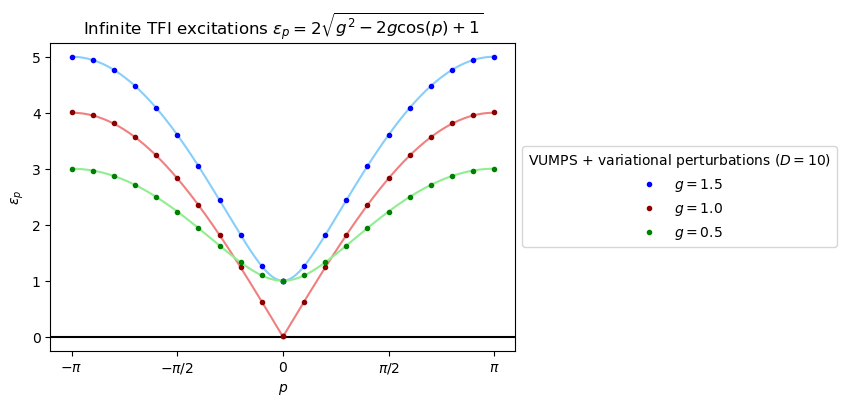

In [6]:
D = 10
tol = 1.e-10
ps_exact, es_exact_para, ps, es_para = get_infinite_tfi_excitation_dispersion(g=1.5, D=D, tol=tol)
_, es_exact_crit, _, es_crit = get_infinite_tfi_excitation_dispersion(g=1., D=D, tol=tol)
_, es_exact_ferro, _, es_ferro = get_infinite_tfi_excitation_dispersion(g=0.5, D=D, tol=tol)

plt.figure(figsize=(6, 4))
plt.title(r"Infinite TFI excitations $\epsilon_p = 2 \sqrt{g^2 - 2g\cos(p) + 1}$")
plt.xticks(np.arange(-np.pi, 3*np.pi/2, np.pi/2), \
           [r"$-\pi$",r"$-\pi /2$", r"$0$", r"$\pi /2$",r"$\pi$"])
plt.axhline(y=0., color="black")
plt.plot(ps_exact, es_exact_para, color="lightskyblue")
plt.plot(ps, es_para, ".", color="blue", label=r"$g = 1.5$")
plt.plot(ps_exact, es_exact_crit, color="lightcoral")
plt.plot(ps, es_crit, ".", color="darkred", label=r"$g = 1.0$")
plt.plot(ps_exact, es_exact_ferro, color="lightgreen")
plt.plot(ps, es_ferro, ".", color="green", label=r"$g = 0.5$")
plt.xlabel(r"$p$")
plt.ylabel(r"$\epsilon_p$")
plt.legend(title=f"VUMPS + variational perturbations ($D = {D}$)", loc='center left', \
           bbox_to_anchor=(1, 0.5))
plt.show()

### 2.2) Finite MPS: Variational site dependent perturbations

* PBC MPO (and OBC MPS): Do the excitations have definite momentum?

In [7]:
def get_degeneracies(Es, psis, tol):
    """For a list Es of eigenvalues and a list psis of corresponding eigenvectors, find degeneracies
    up to tolerance tol."""
    k = len(Es)
    H_deg = {}
    for i in range(k):
        E_i = Es[i]
        psi_i = psis[i]
        contained_i = False
        for E in H_deg:
            if np.allclose(E_i, E, rtol=tol, atol=0):
                H_deg[E].append(psi_i)
                contained_i = True
                break
        if not contained_i:
            H_deg[E_i] = [psi_i]
    return H_deg

def diagonalize_translation_operator(H_deg, get_translation_overlap):
    """For H_deg a dictionary with eigenenergies as keys and degenerate eigenvectors as values,
    build the translation matrix with get_translation_overlap and diagonalize it."""
    H_deg_diagt = {}
    for E in H_deg:
        psis = H_deg[E]
        l = len(psis)
        T_E = np.zeros((l, l), dtype=complex)
        for i in range(l):
            for j in range(l):
                T_E[i, j] = get_translation_overlap(psis[j], psis[i])
        ts, phis = np.linalg.eig(T_E)
        H_deg_diagt[E] = [ts, phis, psis]
    return H_deg_diagt

def t_to_p(t, N):
    """For a translation eigenvalue t = e^{i * (2pi/N) * p}, compute the integer momentum p."""
    return N/(2 * np.pi) * np.angle(t)

def get_finite_tfi_excitations_pbc(N, g, D_max, eps, k):
    """For the TFI model on a finite chain of length N with periodic boundary conditions and 
    transverse field g, find the ground state with DMRG and k variational quasiparticle excitations 
    on top. For each degenerate subspace, diagonalize the translation operator."""
    tfi_model_finite = TFIModelFinite(N, g)
    # exact analytical single particle excitations
    ps_dis, es_dis, ps_con, es_con = tfi_model_finite.get_exact_excitation_dispersion()
    # energy ground state with dmrg
    E0, mps0, _ = get_finite_tfi_gs(N, bc="periodic", g=g, D_max=D_max, eps=eps, num_runs=10)
    # energy excitations and degeneracies
    mpo = tfi_model_finite.get_mpo(bc="periodic")
    excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo)
    if g >= 1.:  # paramagnetic phase (and critical point): unique symmetric ground state
        es_excited, empss = excitation_engine.run(k)
    elif 0 <= g < 1.:  # ferromagnetic phase: two-fold degenerate symmetry broken ground states
        es, empss = excitation_engine.run(k+1)
        es_excited, empss = es[1:], empss[1:]
    H_deg = get_degeneracies(es_excited, empss, tol=1.e-5)  # {e: [empss]}
    empss_sup_p = empss  # superposition of states with definite momentum
    # translation diagonalization
    def get_translation_overlap(emps1, emps2):
        return emps1.get_translation_overlap(emps2)
    H_deg_diagt = diagonalize_translation_operator(H_deg, get_translation_overlap)
    # {e: [ts, phis, empss]}
    ps = []
    es = []
    empss = []
    for e in H_deg_diagt:
        ts_e, phis_e, empss_e = H_deg_diagt[e]
        ps_e = t_to_p(ts_e, N)
        l = len(ps_e)
        for i in range(l):
            ps.append(ps_e[i])
            phi_i = phis_e[:, i]
            vecX_i = np.zeros(empss_e[0].shape_vecX, dtype=complex)
            for j in range(l):
                vecX_i += phi_i[j] * empss_e[j].vecX
            emps_i = ExcitedMPS(empss_e[0].ALs, empss_e[0].ARs, vecX_i)
            empss.append(emps_i)  # state with definite momentum
            e_i = emps_i.get_mpo_expectation_value(mpo) - E0
            assert np.allclose(e_i, e)
            es.append(e)
    print(f"Found {k} momentum resolved variational quasiparticle excitations on top of ground state.")
    return ps_dis, es_dis, ps_con, es_con, empss_sup_p, ps, es, empss

def get_finite_tfi_excitations_pbc_ed(N, g, k):
    """For the TFI model on a finite chain of length N with periodic boundary conditions and 
    transverse field g, find the ground state and excitations with exact diagonalization. For each 
    degenerate subspace, diagonalize the translation operator."""
    print(f"N = {N}, g = {g}:")
    tfi_model_finite = TFIModelFinite(N, g)
    # energy diagonalization and degeneracies
    H = tfi_model_finite.get_H(bc="periodic")
    if g >= 1.:  # paramagnetic phase (and critical point): unique symmetric ground state
        Es, psis = sparse.linalg.eigsh(H, k=k+1, which="SA")
    elif 0 <= g < 1.:  # ferromagnetic phase: two-fold degenerate symmetry broken ground states
        Es, psis = sparse.linalg.eigsh(H, k=k+2, which="SA")
        Es, psis = Es[1:], psis[:, 1:]
    E0 = Es[0]
    Es_excited = Es[1:]
    psis_excited = [psis[:, i] for i in range(1, k+1)]
    H_deg = get_degeneracies(Es_excited, psis_excited, tol=1.e-5)
    psis_sup_p = psis_excited  # superposition of states with definite momentum
    # translation diagonalization
    T = tfi_model_finite.get_T()
    def get_translation_overlap(psi, phi):
        return np.inner(np.conj(phi), T @ psi)
    H_deg_diagt = diagonalize_translation_operator(H_deg, get_translation_overlap)
    # {E: [ts, phis, psis]}
    ps = []
    es = []
    psis = []
    for E in H_deg_diagt:
        ts_E, phis_E, psis_E = H_deg_diagt[E]
        ps_E = t_to_p(ts_E, N)
        l = len(ps_E)
        for i in range(l):
            ps.append(ps_E[i])
            phi_i = phis_E[:, i]
            psi_i = np.zeros(np.shape(psis_E[0]), dtype=complex)
            for j in range(l):
                psi_i += phi_i[j] * psis_E[j]
            psis.append(psi_i)  # state with definite momentum
            E_i = np.inner(np.conj(psi_i), H @ psi_i)
            assert np.allclose(E_i, E)
            es.append(E - E0)
    print(f"Found {k} momentum resolved excitations with exact diagonalization.")
    return psis_sup_p, ps, es, psis

N = 20, bc = periodic, g = 1.5, D_max = 50:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -33.438568868425065. 
Ground state variance: 4.547473508864641e-13. 
Bond dimensions: [1, 2, 4, 8, 16, 32, 50, 50, 50, 50, 50, 50, 50, 50, 50, 32, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 8.888463965206483e-05.
Mean magnetizations: -2.390635947766345e-16 (X) and 0.8773011174185467 (Z).


/Users/lukas/micromamba/envs/masterthesis_env/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:549: ComplexWarning: Casting complex values to real discards the imaginary part
  self.workd[yslice] = self.OP(self.workd[xslice])


Found 40 momentum resolved variational quasiparticle excitations on top of ground state.
N = 20, g = 1.5:
Found 40 momentum resolved excitations with exact diagonalization.


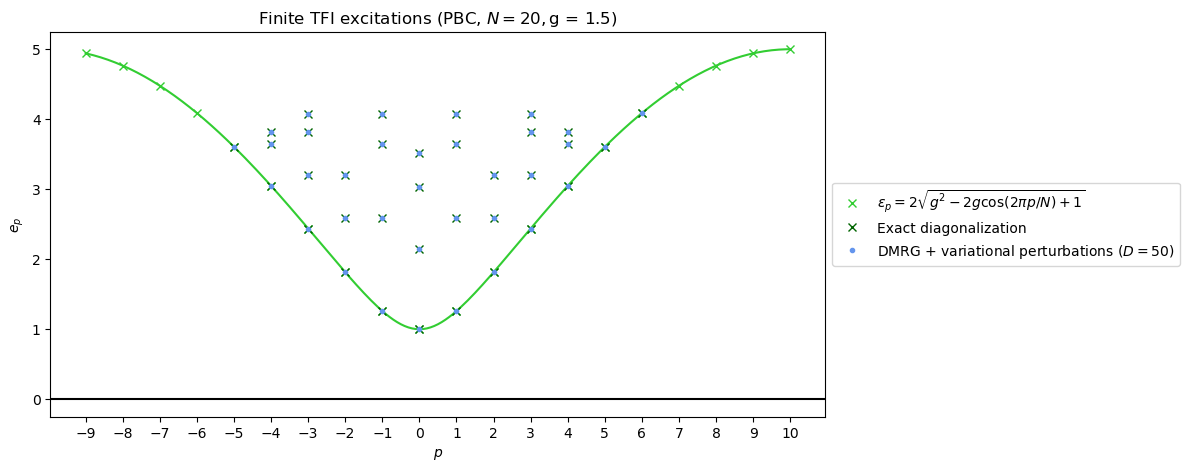

N = 20, bc = periodic, g = 0.5, D_max = 50:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -21.270888306919353. 
Ground state variance: -1.5916157281026244e-12. 
Bond dimensions: [1, 2, 4, 8, 16, 32, 50, 50, 50, 50, 50, 50, 50, 50, 50, 32, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 2.1490409807256583e-07.
Mean magnetizations: 3.695625833216807e-08 (X) and 0.2586581162644737 (Z).
Found 40 momentum resolved variational quasiparticle excitations on top of ground state.
N = 20, g = 0.5:
Found 40 momentum resolved excitations with exact diagonalization.


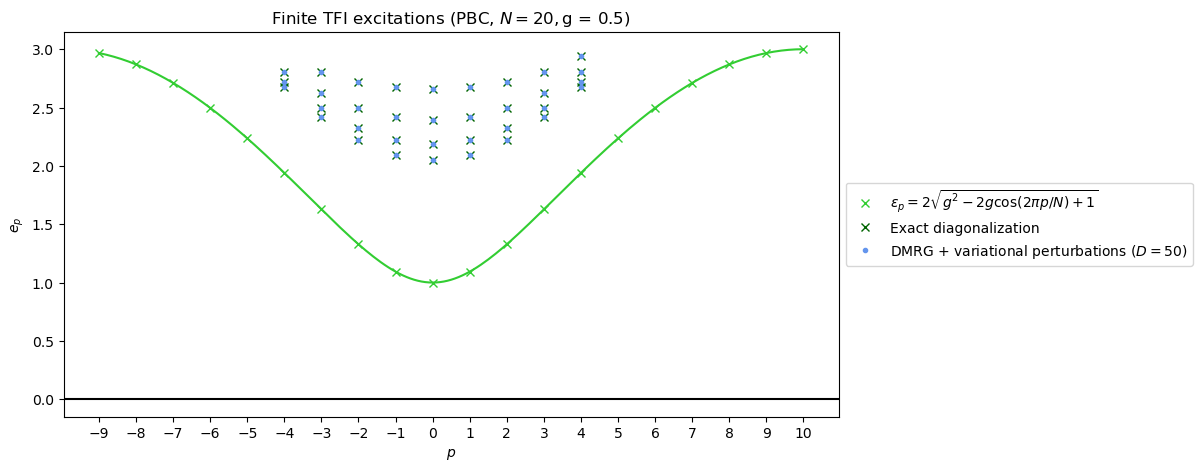

In [8]:
N = 20
D_max = 50
eps = 1.e-16
k = 2 * N

g = 1.5
ps_dis, es_dis, ps_con, es_con, empss_sup_p, ps, es, empss \
    = get_finite_tfi_excitations_pbc(N, g, D_max, eps, k)
psis_sup_p, ps_ed, es_ed, psis_ed = get_finite_tfi_excitations_pbc_ed(N, g, k)
plt.figure(figsize=(10, 5))
plt.title(f"Finite TFI excitations (PBC, $N = {N}, $g = {g})")
plt.xticks(TFIModelFinite(N, g).get_ps())
plt.axhline(y=0., color="black")
plt.plot(ps_dis, es_dis, "x", color="limegreen", \
         label=r"$\epsilon_p = 2 \sqrt{g^2 - 2g\cos(2\pi p/N) + 1}$")
plt.plot(ps_con, es_con, "-", color="limegreen")
plt.plot(ps_ed[:-5], es_ed[:-5], "x", color="darkgreen", label="Exact diagonalization")
plt.plot(ps[:-5], es[:-5], ".", color="cornflowerblue", \
         label=f"DMRG + variational perturbations ($D = {D_max}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$e_p$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

g = 0.5
ps_dis, es_dis, ps_con, es_con, empss_sup_p, ps, es, empss \
    = get_finite_tfi_excitations_pbc(N, g, D_max, eps, k)
psis_sup_p, ps_ed, es_ed, psis_ed = get_finite_tfi_excitations_pbc_ed(N, g, k)
plt.figure(figsize=(10, 5))
plt.title(f"Finite TFI excitations (PBC, $N = {N}, $g = {g})")
plt.xticks(TFIModelFinite(N, g).get_ps())
plt.axhline(y=0., color="black")
plt.plot(ps_dis, es_dis, "x", color="limegreen", \
         label=r"$\epsilon_p = 2 \sqrt{g^2 - 2g\cos(2\pi p/N) + 1}$")
plt.plot(ps_con, es_con, "-", color="limegreen")
plt.plot(ps_ed[:-5], es_ed[:-5], "x", color="darkgreen", label="Exact diagonalization")
plt.plot(ps[:-5], es[:-5], ".", color="cornflowerblue", \
         label=f"DMRG + variational perturbations ($D = {D_max}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$e_p$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

* PBC MPO: Explicitly target momenta with effective translation operator

In [9]:
def get_finite_tfi_excitation_dispersion(N, g, D_max, eps):
    """For the TFI model on a finite chain of length N with periodic boundary conditions and 
    transverse field g, find the ground state with DMRG and the single particle excitation 
    dispersion on top by simultaneously diagonalizing the effective quasiparticle hamiltonian and 
    translation operator."""
    tfi_model_finite = TFIModelFinite(N, g)
    # exact analytical excitation disperion relation
    ps_dis, es_dis, ps_con, es_con = tfi_model_finite.get_exact_excitation_dispersion()
    # ground state with dmrg
    _, mps0, _ = get_finite_tfi_gs(N, bc="periodic", g=g, D_max=D_max, eps=eps, num_runs=10)
    # variational excitation disperion relation
    mpo = tfi_model_finite.get_mpo(bc="periodic")
    ps = tfi_model_finite.get_ps()
    ps_actual = []
    es = []
    empss = []
    for p in ps:
        excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo, p)
        # ferromagnetic phase: two-fold degenerate symmetry broken ground states
        if p == 0 and 0 <= g < 1.: 
            es0, empss0 = excitation_engine.run(k=2)
            e = es0[1]
            emps = empss0[1]
            p_actual = N/(2 * np.pi) * np.angle(emps.get_translation_overlap())
            ps_actual.append(p_actual)
            es.append(e)
            empss.append(emps)
        else:
            e, emps = excitation_engine.run(k=1)
            p_actual = N/(2 * np.pi) * np.angle(emps.get_translation_overlap())
            ps_actual.append(p_actual)
            es.append(e)
            empss.append(emps)
        print(f"Found variational quasiparticle excitation with momentum {p_actual} and energy {e} " \
              + f"on top of ground state.")
    return ps_dis, es_dis, ps_con, es_con, ps_actual, es, empss

N = 40, bc = periodic, g = 1.5, D_max = 30:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -66.87704886994604. 
Ground state variance: 6.741174729540944e-09. 
Bond dimensions: [1, 2, 4, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 1.773550195593998e-08.
Mean magnetizations: -2.9562027190311756e-15 (X) and 0.8773282095834446 (Z).
Found variational quasiparticle excitation with momentum -19.000000004844395 and energy 4.9852042937807255 on top of ground state.
Found variational quasiparticle excitation with momentum -17.999999999301405 and energy 4.9409187949720135 on top of ground state.
Found variational quasiparticle excitation with momentum -16.999999997576236 and energy 4.867451048444842 on top of ground state.
Found variational quasiparticle excitation with momentum -15.999999994558468 and energy 4.765312651850941 on top of ground state

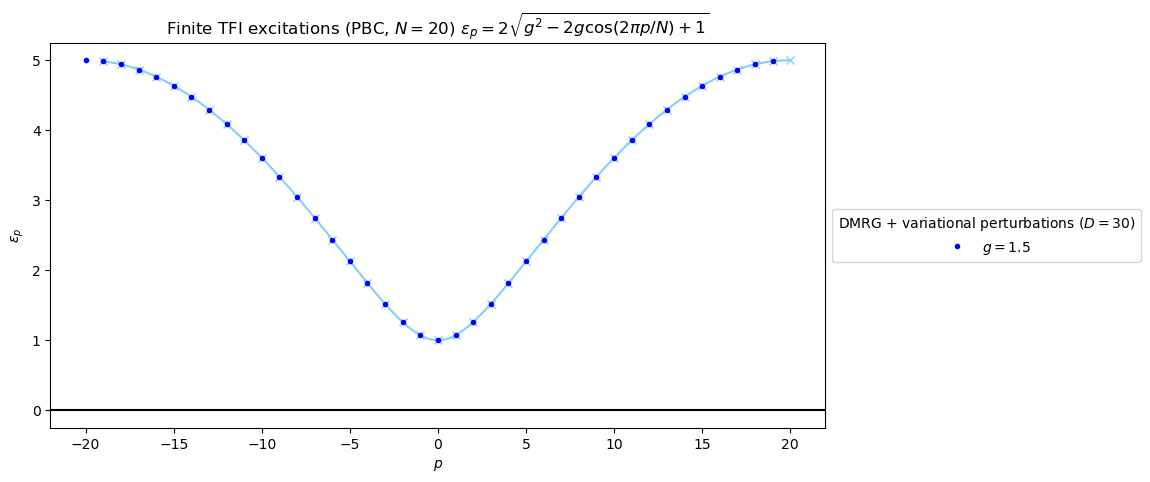

In [10]:
N = 40
D_max = 30
eps = 1.e-12

ps_dis, es_dis_para, ps_con, es_con_para, ps_para, es_para, empss_para \
    = get_finite_tfi_excitation_dispersion(N, g=1.5, D_max=D_max, eps=eps)

plt.figure(figsize=(10, 5))
plt.title(r"Finite TFI excitations (PBC, $N = 20$) $\epsilon_p = 2 \sqrt{g^2 - 2g\cos(2\pi p/N) + 1}$ ")
plt.axhline(y=0., color="black")

plt.plot(ps_dis, es_dis_para, "x", color="lightskyblue")
plt.plot(ps_con, es_con_para, "-", color="lightskyblue")
plt.plot(ps_para, es_para, ".", color="blue", label=r"$g = 1.5$")

plt.xlabel(r"$p$")
plt.ylabel(r"$\epsilon_p$")
plt.legend(title=f"DMRG + variational perturbations ($D = {D_max}$)", loc='center left', \
           bbox_to_anchor=(1, 0.5))
plt.show()

* PBC MPO: Local energies

N = 100, bc = periodic, g = 1.5, D_max = 50:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -167.1926044682639. 
Ground state variance: 0.00017904631022247486. 
Bond dimensions: [1, 2, 4, 8, 16, 32, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 32, 16, 8, 4, 2, 1].
|E0 - E0_exact| = 1.7685355572893968e-05.
Mean magnetizations: 8.887387244250181e-14 (X) and 0.8773293097235053 (Z).
Found 5 momentum resolved variational quasiparticle excitations on top of ground state.
N = 100, bc = periodic, g = 1.5, D_max = 50:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -167.1926044682639. 
Ground state variance: 0.00017904631022247486. 
Bo

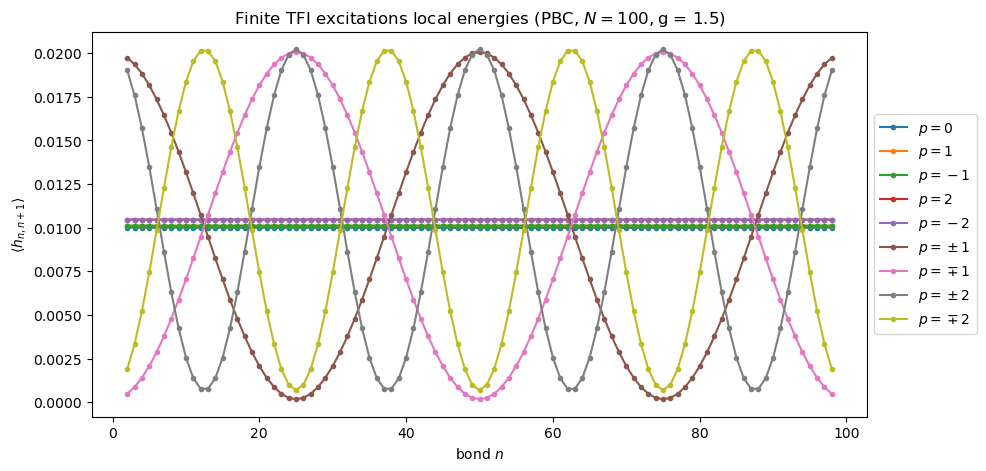

In [11]:
N = 100
g = 1.5
D_max = 50
eps = 1.e-16
k = 5

_, _, _, _, empss_sup_p, _, _, empss = get_finite_tfi_excitations_pbc(N, g, D_max, eps, k)

tfi_model_finite = TFIModelFinite(N, g)
h_bonds = tfi_model_finite.get_h_bonds()
_, mps0, _ = get_finite_tfi_gs(N, bc="periodic", g=g, D_max=50, eps=1.e-16, num_runs=10)
E_bonds_gs = mps0.get_bond_expectation_values(h_bonds)

ns = range(2, N-1)

E_bonds_0 = empss[0].get_bond_expectation_values(h_bonds)
e_bonds_0 = [E_bonds_0[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_p1 = empss[1].get_bond_expectation_values(h_bonds)
e_bonds_p1 = [E_bonds_p1[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_m1 = empss[2].get_bond_expectation_values(h_bonds)
e_bonds_m1 = [E_bonds_m1[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_p2 = empss[3].get_bond_expectation_values(h_bonds)
e_bonds_p2 = [E_bonds_p2[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_m2 = empss[4].get_bond_expectation_values(h_bonds)
e_bonds_m2 = [E_bonds_m2[n] - E_bonds_gs[n] for n in range(1, N-2)]

E_bonds_pm1 = empss_sup_p[1].get_bond_expectation_values(h_bonds)
e_bonds_pm1 = [E_bonds_pm1[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_mp1 = empss_sup_p[2].get_bond_expectation_values(h_bonds)
e_bonds_mp1 = [E_bonds_mp1[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_pm2 = empss_sup_p[3].get_bond_expectation_values(h_bonds)
e_bonds_pm2 = [E_bonds_pm2[n] - E_bonds_gs[n] for n in range(1, N-2)]
E_bonds_mp2 = empss_sup_p[4].get_bond_expectation_values(h_bonds)
e_bonds_mp2 = [E_bonds_mp2[n] - E_bonds_gs[n] for n in range(1, N-2)]

plt.figure(figsize=(10, 5))
plt.title(f"Finite TFI excitations local energies (PBC, $N = {N}, $g = {g})")

plt.plot(ns, e_bonds_0, ".-", label=r"$p = 0$")
plt.plot(ns, e_bonds_p1, ".-", label=r"$p = 1$")
plt.plot(ns, e_bonds_m1, ".-", label=r"$p = -1$")
plt.plot(ns, e_bonds_p2, ".-", label=r"$p = 2$")
plt.plot(ns, e_bonds_m2, ".-", label=r"$p = -2$")

plt.plot(ns, e_bonds_pm1, ".-", label=r"$p = \pm 1$")
plt.plot(ns, e_bonds_mp1, ".-", label=r"$p = \mp 1$")
plt.plot(ns, e_bonds_pm2, ".-", label=r"$p = \pm 2$")
plt.plot(ns, e_bonds_mp2, ".-", label=r"$p = \mp 2$")

plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

* OBC MPO: Local energies

In [12]:
def get_finite_tfi_excitations_obc(N, g, D_max, eps, k):
    """For the TFI model on a finite chain of length N with open boundary conditions and transverse 
    field g, find the ground state with DMRG and k variational quasiparticle excitations on top. 
    Compute the local energies for all excited states."""
    tfi_model_finite = TFIModelFinite(N, g)
    # ground state with dmrg
    _, mps0, mx0 = get_finite_tfi_gs(N, bc="open", g=g, D_max=D_max, eps=eps, num_runs=10)
    # variational quasiparticle excitations
    mpo = tfi_model_finite.get_mpo(bc="open")
    # paramagnetic phase (single spin flip excitations) and critical point (gapless excitation)
    if g >= 1.:  
        excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo)
        es, empss = excitation_engine.run(k)
    elif 0 <= g < 1:  # ferromagnetic phase (topological domain wall excitations)
        for i in range(100):
            _, mps0_tilde, mx0_tilde = get_finite_tfi_gs(N, bc="open", g=g, D_max=D_max, eps=eps, \
                                                         num_runs=10)
            if np.abs(mx0 + mx0_tilde) < 1.e-5:
                print(f"Found mx0={mx0} and mx0_tilde={mx0_tilde} after {i+2} ground state searchs.")
                excitation_engine = VariationalQuasiparticleExcitationEngine(mps0, mpo, p=None, \
                                                                             mps0_tilde=mps0_tilde)
                es, empss = excitation_engine.run(k+1)
                es, empss = es[1:], empss[1:]
                break
    print(f"Found {k} variational quasiparticle excitations on top of ground state. \n" \
          + f"Energies: {es}.")
    # local energies
    h_bonds = tfi_model_finite.get_h_bonds()
    E_bonds_gs = mps0.get_bond_expectation_values(h_bonds)
    e_bondss = []
    for emps in empss:
        E_bonds_i = emps.get_bond_expectation_values(h_bonds)
        e_bonds_i = [E_bonds_i[n] - E_bonds_gs[n] for n in range(N-1)]
        e_bondss.append(e_bonds_i)
    return es, e_bondss, empss

def get_finite_tfi_excitations_obc_ed(N, g, k):
    """For the TFI model on a finite chain of length N with open boundary conditions and 
    transverse field g, find the ground state and k excitations with exact diagonalization. Compute 
    the local energies for all excited states."""
    print(f"N = {N}, g = {g}:")
    tfi_model_finite = TFIModelFinite(N, g)
    # exact diagonaization
    H = tfi_model_finite.get_H(bc="open")
    # paramagnetic phase (single spin flip excitations) and critical point (gapless excitation)
    if g >= 1.:
        Es, psis = sparse.linalg.eigsh(H, k=k+1, which="SA")
        E0 = Es[0]
        psi0 = psis[:, 0]
        es = Es[1:] - E0
        psis_excited = [psis[:, i] for i in range(1, k+1)]
    elif 0 <= g < 1.:  # ferromagnetic phase (topological domain wall excitations)
        Es, psis = sparse.linalg.eigsh(H, k=k+2, which="SA")
        E0 = Es[0]
        psi0 = psis[:, 0]
        es = Es[2:] - E0
        psis_excited = [psis[:, i] for i in range(2, k+2)]
    print(f"Found {k} excitations with exact diagonalization. \n"
          + f"Energies: {es}.")
    # local energies
    H_bonds = tfi_model_finite.get_H_bonds(bc="open")
    E_bonds_gs = [np.inner(np.conj(psi0), H_bond @ psi0) for H_bond in H_bonds]
    e_bondss = []
    for i in range(k):
        psi_i = psis_excited[i]
        e_bonds_i = [np.inner(np.conj(psi_i), H_bonds[n] @ psi_i) - E_bonds_gs[n] for n in range(N-1)]
        e_bondss.append(e_bonds_i)
    return es, e_bondss, psis_excited

N = 20, bc = open, g = 1.5, D_max = 20:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -33.25451675363548. 
Ground state variance: -3.410605131648481e-12. 
Bond dimensions: [1, 2, 4, 8, 13, 17, 20, 20, 20, 20, 20, 20, 20, 20, 20, 17, 13, 8, 4, 2, 1].
Mean magnetizations: 1.5023306180774344e-16 (X) and 0.8849317206347745 (Z).
Found 4 variational quasiparticle excitations on top of ground state. 
Energies: [1.0548117697296462, 1.2069993058156712, 1.4291212712505903, 1.6940690935036038].
N = 20, g = 1.5:
Found 4 excitations with exact diagonalization. 
Energies: [1.05481177 1.20699931 1.42912127 1.69406909].


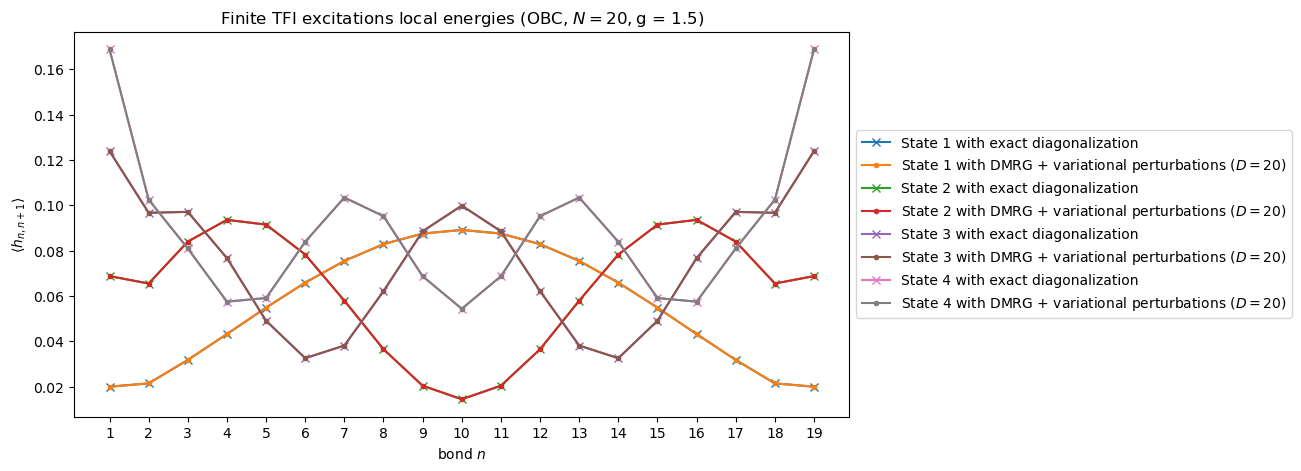

In [13]:
N = 20
g = 1.5
D = 20
eps = 1.e-10
k = 4

es, e_bondss, empss = get_finite_tfi_excitations_obc(N, g, D, eps, k)
es_ed, e_bondss_ed, psis_ed = get_finite_tfi_excitations_obc_ed(N, g, k)

plt.figure(figsize=(10, 5))
plt.title(f"Finite TFI excitations local energies (OBC, $N = {N}, $g = {g})")
plt.xticks(range(1, N))
for i in range(k):
    plt.plot(range(1, N), e_bondss_ed[i], "x-", label=f"State {i+1} with exact diagonalization")
    plt.plot(range(1, N), e_bondss[i], ".-", \
             label=f"State {i+1} with DMRG + variational perturbations ($D = {D}$)")
plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

N = 100, bc = open, g = 1.5, D_max = 30:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -167.00861447648953. 
Ground state variance: -4.94765117764473e-10. 
Bond dimensions: [1, 2, 4, 8, 15, 22, 25, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 29, 25, 22, 15, 8, 4, 2, 1].
Mean magnetizations: 1.4917549340324222e-16 (X) and 0.8788489163351323 (Z).
Found 50 variational quasiparticle excitations on top of ground state. 
Energies: [1.002787065622897, 1.0111025431430107, 1.0248126913383544, 1.043705418341176, 1.0675046391119452, 1.095887195152443, 1.1285001774281511, 1.1649768835729049, 1.2049502554287415, 1.2480632778222969, 1.2939763340929176, 1.3423718504765816, 1.39

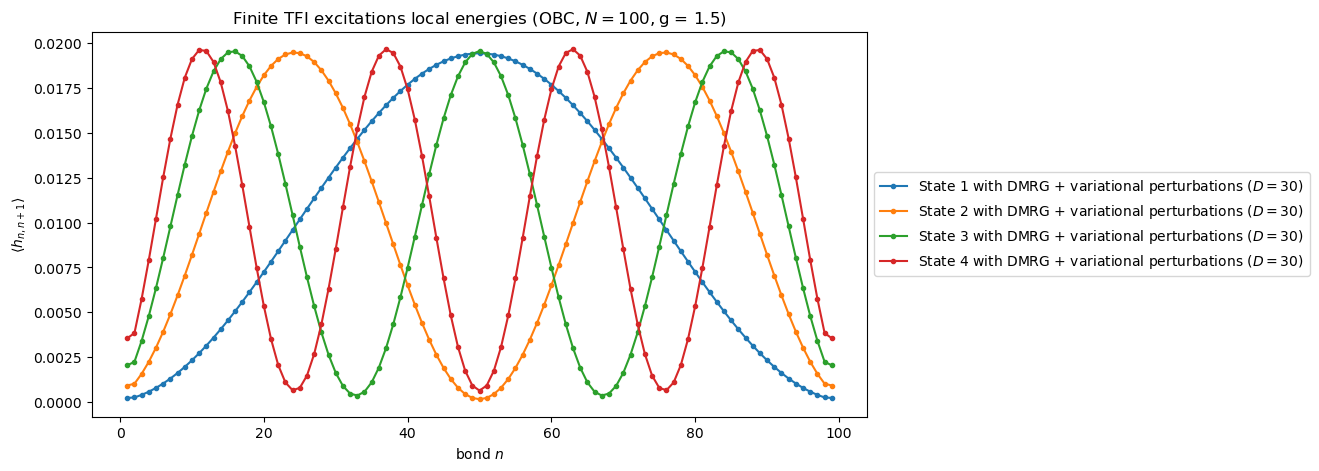

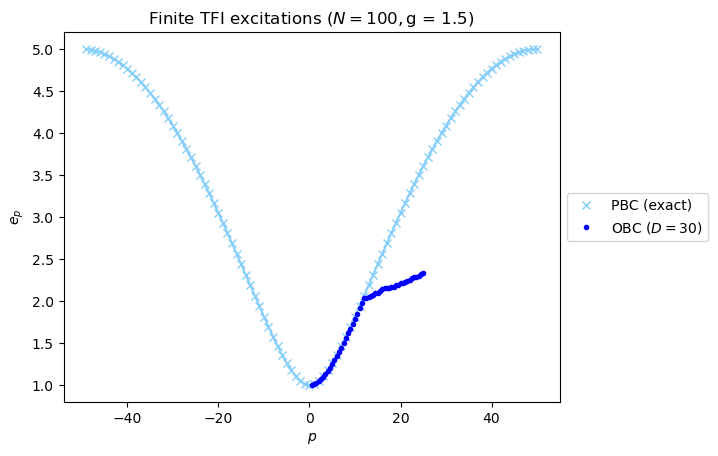

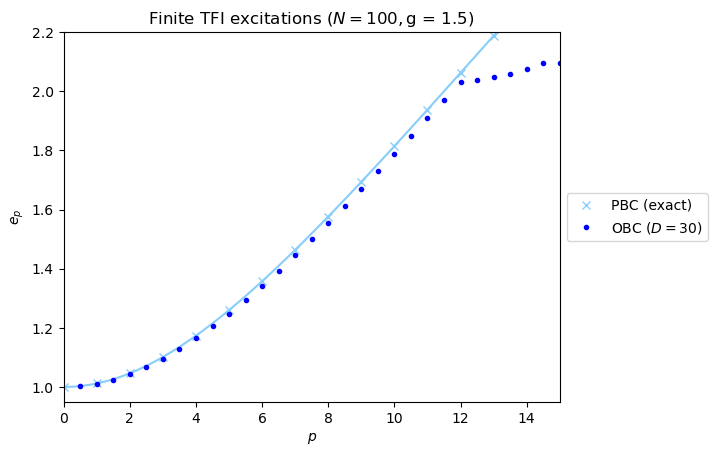

N = 100, bc = open, g = 0.5, D_max = 30:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -105.48376994964431. 
Ground state variance: -2.346496330574155e-10. 
Bond dimensions: [1, 2, 4, 8, 13, 16, 17, 18, 19, 19, 19, 19, 17, 17, 17, 16, 16, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 19, 19, 19, 19, 18, 17, 16, 13, 8, 4, 2, 1].
Mean magnetizations: 0.9622412536342209 (X) and 0.2640238146471041 (Z).
N = 100, bc = open, g = 0.5, D_max = 30:
Performed MPS ground state search with 10 DMRG runs. 
Ground state energy: -105.48376994964431. 
Ground state variance: -2.346496330574155e-10. 
Bond dimensions: [1, 2, 4, 8, 13, 16, 17, 18, 19, 19, 19, 19, 17, 17, 17, 16, 16, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,

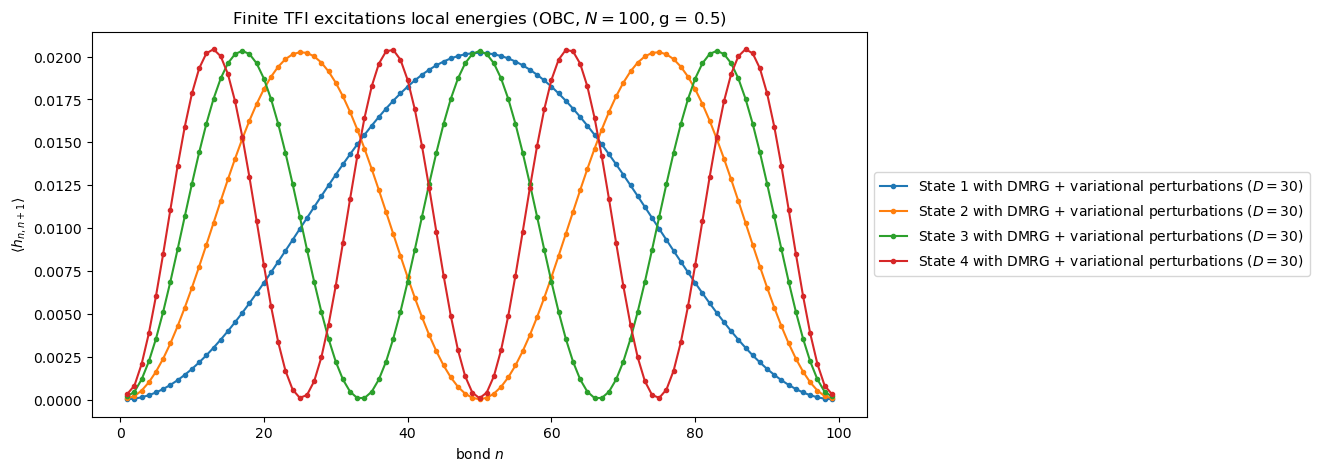

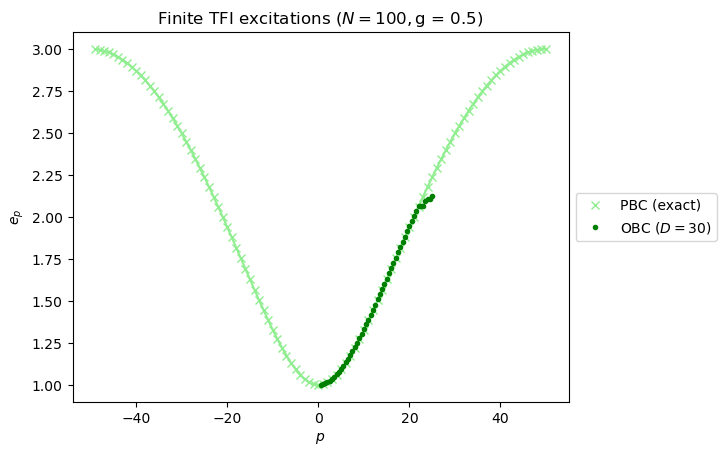

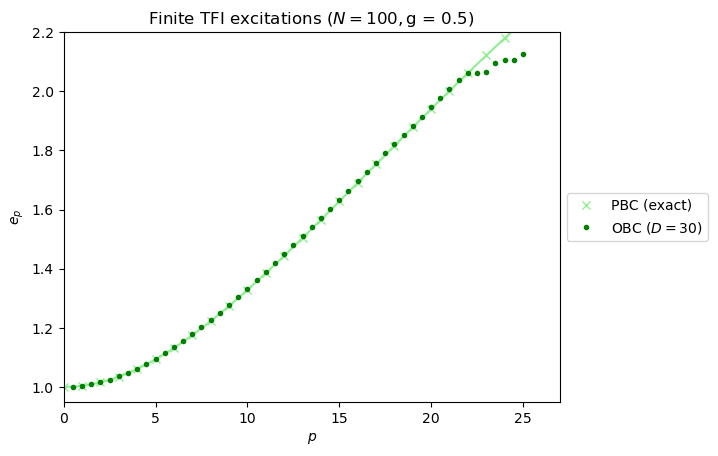

In [14]:
N = 100
D = 30
eps = 1.e-12
k = 50

g = 1.5
es, e_bondss, empss = get_finite_tfi_excitations_obc(N, g, D, eps, k)
plt.figure(figsize=(10, 5))
plt.title(f"Finite TFI excitations local energies (OBC, $N = {N}, $g = {g})")
for i in range(4):
    plt.plot(range(1, N), e_bondss[i], ".-", \
             label=f"State {i+1} with DMRG + variational perturbations ($D = {D}$)")
plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
tfi_model_finite = TFIModelFinite(N, g)
ps_dis, es_dis, ps_con, es_con = tfi_model_finite.get_exact_excitation_dispersion()
ps_open = np.arange(0.5, k/2. + 0.5, 0.5)
plt.figure()
plt.title(f"Finite TFI excitations ($N = {N}, $g = {g})")
plt.plot(ps_dis, es_dis, "x", color="lightskyblue", label="PBC (exact)")
plt.plot(ps_con, es_con, "-", color="lightskyblue")
plt.plot(ps_open, es, ".", color="blue", label=f"OBC ($D = {D}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$e_p$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.figure()
plt.title(f"Finite TFI excitations ($N = {N}, $g = {g})")
plt.plot(ps_dis, es_dis, "x", color="lightskyblue", label="PBC (exact)")
plt.plot(ps_con, es_con, "-", color="lightskyblue")
plt.plot(ps_open, es, ".", color="blue", label=f"OBC ($D = {D}$)")
plt.xlim(0., 15.)
plt.ylim(0.95, 2.2)
plt.xlabel(r"$p$")
plt.ylabel(r"$e_p$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

g = 0.5
es, e_bondss, empss = get_finite_tfi_excitations_obc(N, g, D, eps, k)
plt.figure(figsize=(10, 5))
plt.title(f"Finite TFI excitations local energies (OBC, $N = {N}, $g = {g})")
for i in range(4):
    plt.plot(range(1, N), e_bondss[i], ".-", \
             label=f"State {i+1} with DMRG + variational perturbations ($D = {D}$)")
plt.xlabel(r"bond $n$")
plt.ylabel(r"$\langle h_{n, n+1} \rangle$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
tfi_model_finite = TFIModelFinite(N, g)
ps_dis, es_dis, ps_con, es_con = tfi_model_finite.get_exact_excitation_dispersion()
ps_open = np.arange(0.5, k/2. + 0.5, 0.5)
plt.figure()
plt.title(f"Finite TFI excitations ($N = {N}, $g = {g})")
plt.plot(ps_dis, es_dis, "x", color="lightgreen", label="PBC (exact)")
plt.plot(ps_con, es_con, "-", color="lightgreen")
plt.plot(ps_open, es, ".", color="green", label=f"OBC ($D = {D}$)")
plt.xlabel(r"$p$")
plt.ylabel(r"$e_p$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.figure()
plt.title(f"Finite TFI excitations ($N = {N}, $g = {g})")
plt.plot(ps_dis, es_dis, "x", color="lightgreen", label="PBC (exact)")
plt.plot(ps_con, es_con, "-", color="lightgreen")
plt.plot(ps_open, es, ".", color="green", label=f"OBC ($D = {D}$)")
plt.xlim(0., 27)
plt.ylim(0.95, 2.2)
plt.xlabel(r"$p$")
plt.ylabel(r"$e_p$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()